In [6]:
import torch
from scipy.stats import qmc
from pytorch3d.renderer.cameras import look_at_view_transform

DISTANCE_TO_OBJ = 3.0

import plotly.graph_objects as go

def sample_camera_params_with_visualization(
    poisson_r: float, num_samples: int
):
    engine = qmc.PoissonDisk(d=3, radius=poisson_r, hypersphere="surface", ncandidates=8)
    positions = torch.tensor(engine.random(num_samples), dtype=torch.float32)
    x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]
    
    # Create a 3D scatter plot
    fig = go.Figure(data=go.Scatter3d(
        x=x.numpy(),
        y=y.numpy(),
        z=z.numpy(),
        mode='markers',
        marker=dict(
            size=5,
            color=z.numpy(),  # Color by z-coordinate
            colorscale='Viridis',
            opacity=0.8
        )
    ))
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        title="3D Visualization of Sampled Points"
    )
    fig.show()
    
    dist = torch.norm(positions, dim=1) * DISTANCE_TO_OBJ
    elev = torch.asin(y / dist) * 180 / torch.pi
    azim = torch.atan2(x, z) * 180 / torch.pi
    R, T = look_at_view_transform(dist, elev, azim)
    return R, T

# Example usage
poisson_r = 0.1
num_samples = 1000
sample_camera_params_with_visualization(poisson_r, num_samples)

(tensor([[[-0.8181, -0.0889, -0.5682],
          [ 0.0000,  0.9880, -0.1546],
          [ 0.5751, -0.1265, -0.8082]],
 
         [[-0.8119, -0.0991, -0.5753],
          [ 0.0000,  0.9855, -0.1697],
          [ 0.5838, -0.1378, -0.8001]],
 
         [[-0.8019, -0.0805, -0.5920],
          [ 0.0000,  0.9909, -0.1347],
          [ 0.5975, -0.1080, -0.7946]],
 
         ...,
 
         [[-0.0136, -0.2997, -0.9539],
          [ 0.0000,  0.9540, -0.2997],
          [ 0.9999, -0.0041, -0.0129]],
 
         [[-0.9177, -0.0601, -0.3928],
          [ 0.0000,  0.9885, -0.1511],
          [ 0.3974, -0.1387, -0.9071]],
 
         [[-0.9974, -0.0207, -0.0684],
          [ 0.0000,  0.9573, -0.2891],
          [ 0.0715, -0.2884, -0.9548]]]),
 tensor([[ 8.1810e-08,  3.2451e-08,  3.6362e+00],
         [ 5.1940e-09, -4.0797e-08,  3.3998e+00],
         [-1.5915e-08,  2.1466e-08,  3.7817e+00],
         ...,
         [-6.3771e-10,  5.5068e-08,  2.5241e+00],
         [-2.5872e-09, -4.2385e-09,  2.9140e-01],


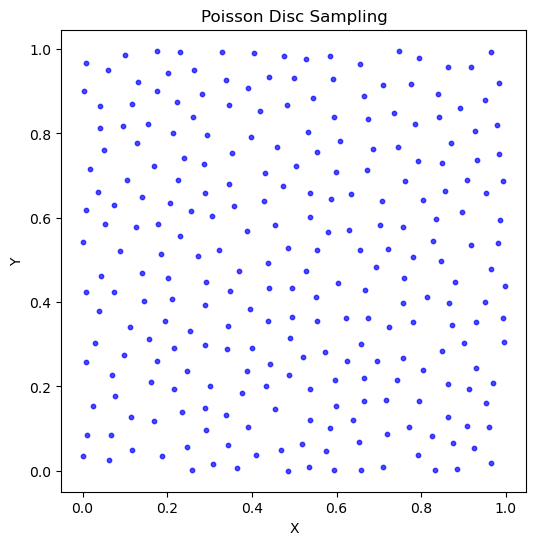

In [17]:
import numpy as np

class PoissonDisc(object):
    """A class for generating two-dimensional Possion (blue) noise)."""

    def __init__(self, rng, width=50, height=50, r=1, k=30):
        self.rng = rng
        self.width, self.height = width, height
        self.r = r
        self.k = k

        # Cell side length
        self.a = r / np.sqrt(2)
        # Number of cells in the x- and y-directions of the grid
        self.nx, self.ny = int(width / self.a) + 1, int(height / self.a) + 1

        self.reset()

    def reset(self):
        """Reset the cells dictionary."""

        # A list of coordinates in the grid of cells
        coords_list = [(ix, iy) for ix in range(self.nx) for iy in range(self.ny)]
        # Initilalize the dictionary of cells: each key is a cell's coordinates
        # the corresponding value is the index of that cell's point's
        # coordinates in the samples list (or None if the cell is empty).
        self.cells = {coords: None for coords in coords_list}

    def get_cell_coords(self, pt):
        """Get the coordinates of the cell that pt = (x,y) falls in."""

        return int(pt[0] // self.a), int(pt[1] // self.a)

    def get_neighbours(self, coords):
        """Return the indexes of points in cells neighbouring cell at coords.
        For the cell at coords = (x,y), return the indexes of points in the
        cells with neighbouring coordinates illustrated below: ie those cells
        that could contain points closer than r.
                                     ooo
                                    ooooo
                                    ooXoo
                                    ooooo
                                     ooo
        """

        dxdy = [
            (-1, -2),
            (0, -2),
            (1, -2),
            (-2, -1),
            (-1, -1),
            (0, -1),
            (1, -1),
            (2, -1),
            (-2, 0),
            (-1, 0),
            (1, 0),
            (2, 0),
            (-2, 1),
            (-1, 1),
            (0, 1),
            (1, 1),
            (2, 1),
            (-1, 2),
            (0, 2),
            (1, 2),
            (0, 0),
        ]
        neighbours = []
        for dx, dy in dxdy:
            neighbour_coords = coords[0] + dx, coords[1] + dy
            if not (
                0 <= neighbour_coords[0] < self.nx
                and 0 <= neighbour_coords[1] < self.ny
            ):
                # We're off the grid: no neighbours here.
                continue
            neighbour_cell = self.cells[neighbour_coords]
            if neighbour_cell is not None:
                # This cell is occupied: store the index of the contained point
                neighbours.append(neighbour_cell)
        return neighbours

    def point_valid(self, pt):
        """Is pt a valid point to emit as a sample?
        It must be no closer than r from any other point: check the cells in
        its immediate neighbourhood.
        """

        cell_coords = self.get_cell_coords(pt)
        for idx in self.get_neighbours(cell_coords):
            nearby_pt = self.samples[idx]
            # Squared distance between candidate point, pt, and this nearby_pt.
            distance2 = (nearby_pt[0] - pt[0]) ** 2 + (nearby_pt[1] - pt[1]) ** 2
            if distance2 < self.r**2:
                # The points are too close, so pt is not a candidate.
                return False
        # All points tested: if we're here, pt is valid
        return True

    def get_point(self, refpt):
        """Try to find a candidate point near refpt to emit in the sample.
        We draw up to k points from the annulus of inner radius r, outer radius
        2r around the reference point, refpt. If none of them are suitable
        (because they're too close to existing points in the sample), return
        False. Otherwise, return the pt.
        """

        i = 0
        while i < self.k:
            rho, theta = (
                self.rng.uniform(self.r, 2 * self.r),
                self.rng.uniform(0, 2 * np.pi),
            )
            pt = refpt[0] + rho * np.cos(theta), refpt[1] + rho * np.sin(theta)
            if not (0 < pt[0] < self.width and 0 < pt[1] < self.height):
                # This point falls outside the domain, so try again.
                continue
            if self.point_valid(pt):
                return pt
            i += 1
        # We failed to find a suitable point in the vicinity of refpt.
        return False

    def sample(self):
        """Poisson disc random sampling in 2D.
        Draw random samples on the domain width x height such that no two
        samples are closer than r apart. The parameter k determines the
        maximum number of candidate points to be chosen around each reference
        point before removing it from the "active" list.
        """

        # Pick a random point to start with.
        pt = (self.rng.uniform(0, self.width), self.rng.uniform(0, self.height))
        self.samples = [pt]
        # Our first sample is indexed at 0 in the samples list...
        self.cells[self.get_cell_coords(pt)] = 0
        # and it is active, in the sense that we're going to look for more
        # points in its neighbourhood.
        active = [0]

        # As long as there are points in the active list, keep looking for
        # samples.
        while active:
            # choose a random "reference" point from the active list.
            idx = self.rng.choice(active)
            refpt = self.samples[idx]
            # Try to pick a new point relative to the reference point.
            pt = self.get_point(refpt)
            if pt:
                # Point pt is valid: add it to samples list and mark as active
                self.samples.append(pt)
                nsamples = len(self.samples) - 1
                active.append(nsamples)
                self.cells[self.get_cell_coords(pt)] = nsamples
            else:
                # We had to give up looking for valid points near refpt, so
                # remove it from the list of "active" points.
                active.remove(idx)

        return self.samples
    
rng = np.random.default_rng(100)
pd  = PoissonDisc(rng, width=1.0, height=1.0, r=0.05, k=30)

import matplotlib.pyplot as plt

# Generate the points
pts = pd.sample()

# Separate the x and y coordinates
x_coords, y_coords = zip(*pts)

# Plot the points
plt.figure(figsize=(6, 6))
plt.scatter(x_coords, y_coords, s=10, color='blue', alpha=0.7)
plt.title("Poisson Disc Sampling")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.show()


In [60]:
import torch
from scipy.stats import qmc
from pytorch3d.renderer.cameras import look_at_view_transform

DISTANCE_TO_OBJ = 3.0
import plotly.graph_objects as go

def sample_camera_params(poisson_r: float, n: int, visualize: bool = True):
    # 1-D engine kept; just convert to radians before trig
    eng = qmc.PoissonDisk(d=2, radius=poisson_r, hypersphere="volume")
    uv = torch.tensor(eng.random(n), dtype=torch.float32)           # u,v ∈ (0,1)
    azim_deg = (uv[:, 0] - 0.5) * 360          # (-180°,180°)
    elev_deg = (uv[:, 1] - 0.5) * 30          # (-10°, 10°)


    if visualize:
        azim = torch.deg2rad(azim_deg)
        elev = torch.deg2rad(elev_deg)
        x = DISTANCE_TO_OBJ * torch.cos(elev) * torch.sin(azim)
        y = DISTANCE_TO_OBJ * torch.sin(elev)
        z = DISTANCE_TO_OBJ * torch.cos(elev) * torch.cos(azim)
        fig = go.Figure(go.Scatter3d(x=x, y=y, z=z, mode="markers"))
        fig.update_layout(
            scene=dict(
                aspectmode="cube",
                xaxis=dict(range=[-DISTANCE_TO_OBJ, DISTANCE_TO_OBJ]),
                yaxis=dict(range=[-DISTANCE_TO_OBJ, DISTANCE_TO_OBJ]),
                zaxis=dict(range=[-DISTANCE_TO_OBJ, DISTANCE_TO_OBJ])
            )
        )
        fig.show()
        
    R, T = look_at_view_transform(DISTANCE_TO_OBJ, elev_deg, azim_deg)
    return R, T


sample_camera_params(0.5, 4)

(tensor([[[ 0.3634,  0.0824,  0.9280],
          [ 0.0000,  0.9961, -0.0885],
          [-0.9316,  0.0322,  0.3620]],
 
         [[ 0.8408, -0.0859, -0.5344],
          [-0.0000,  0.9873, -0.1587],
          [ 0.5413,  0.1335,  0.8302]],
 
         [[ 0.1496,  0.1848, -0.9713],
          [-0.0000,  0.9824,  0.1869],
          [ 0.9887, -0.0280,  0.1470]],
 
         [[ 0.4805, -0.1759,  0.8592],
          [ 0.0000,  0.9797,  0.2006],
          [-0.8770, -0.0964,  0.4707]]]),
 tensor([[-7.4082e-08, -3.3666e-09,  3.0000e+00],
         [-1.0744e-07, -1.1657e-08,  3.0000e+00],
         [-1.3759e-08, -1.4871e-08,  3.0000e+00],
         [ 1.7110e-08, -4.2987e-08,  3.0000e+00]]))